# Annotation Data Analysis

In [1]:
# Importing libraries
import yaml
import pymongo
import pandas as pd
from collections import Counter

In [2]:
# Import plot libraries
import matplotlib.pyplot as plt

### Util functions

In [3]:
# File function - Read dict from YAML file
def get_dict_from_yaml(yaml_path:str, encoding:str="utf-8") -> dict:
    result = dict()
    
    try:
        with open(yaml_path, mode="r", encoding=encoding) as file:
            yaml_file = file.read()
            result = yaml.load(yaml_file, Loader=yaml.FullLoader)
    except Exception as e:
        print(e)
        
    return result

In [4]:
def string_to_list(str_list:str) -> list:
    if str_list == "[]":
        return []
    str_list = str_list.replace("[", "").replace("]", "").replace(" ", "").replace("\n", "")
    return str_list.split(",")

In [5]:
# Util function - Plot column chart
def plot_bar_chart(df, x_var, y_var, title, color='blue', legend=None) -> None:
    fig, ax = plt.subplots()
    df.plot.barh(ax=ax, x=x_var, y=y_var, alpha=0.75, figsize=figsize)
    if legend:
        ax.legend(legend)
    else:
        ax.get_legend().remove()
    plt.title(title, fontsize=16)
    plt.xlabel(y_var.capitalize(), fontsize=10)
    plt.ylabel(x_var.capitalize(), fontsize=10)
    plt.show()

### Read data

In [6]:
# Read MongoDB login info
filepath = "config/mdb_setup.yaml"
mdb_login = get_dict_from_yaml(filepath)

In [7]:
# Create connetion to MongoDB
client  = pymongo.MongoClient(mdb_login['db_server'], mdb_login['db_port'])
db = client[mdb_login['db_name']]
coll = db[mdb_login['db_collection']]

In [8]:
# Query data
doc_list = []
for doc in coll.find({}):
    doc['claim']['nouns'] = string_to_list(doc['claim']['nouns'])
    doc['claim']['entities'] = string_to_list(doc['claim']['entities'])
    doc['majorClaim']['nouns'] = string_to_list(doc['majorClaim']['nouns'])
    doc['majorClaim']['entities'] = string_to_list(doc['majorClaim']['entities'])
    doc['premise']['nouns'] = string_to_list(doc['premise']['nouns'])
    doc['premise']['entities'] = string_to_list(doc['premise']['entities'])
    doc_list.append(doc)

print(">> Number of annotated documents:", len(doc_list))

>> Number of annotated documents: 4702


In [9]:
doc_list[0]

{'_id': ObjectId('618315e580c699e1073e9a16'),
 'argumentID': '5-1',
 'approach': 'A2 -> C+(L+P)',
 'claim': {'text': 'Mi idea es dar un uso al arco de la victoria de Moncloa , en lugar de demolerlo , como soporte',
  'nouns': ['idea',
   'uso',
   'arco',
   'victoria',
   'lugar',
   'demolerlo',
   'soporte'],
  'entities': ['Moncloa']},
 'linker': {'linker': 'para',
  'category': 'CONSEQUENCE',
  'subCategory': 'GOAL',
  'relationType': 'support'},
 'mainVerb': 'dar',
 'majorClaim': {'text': 'Uso artistico y de promocion del  Arco de la Victoria',
  'nouns': ['Uso', 'promocion'],
  'entities': ['de']},
 'premise': {'text': 'promos de actividades en Madrid',
  'nouns': ['promos', 'actividades'],
  'entities': []},
 'proposalID': 5,
 'sentence': 'Mi idea es dar un uso al arco de la victoria de Moncloa, en lugar de demolerlo, como soporte para promos de actividades en Madrid (semana del orgullo gay, congresos mundiales, eventos futbol, etc)'}

## Data Processing

In [10]:
# Local variables
n_top = 20
topic_filter = ""
categories = Counter()
sub_categories = Counter()
linkers = Counter()
relations = Counter()
entities = Counter()
nouns = Counter()
main_verbs = Counter()

In [11]:
# Counting data
for doc in doc_list:
    if doc["sentence"] == "" or topic_filter in doc["sentence"]:
        
        # Linker data
        doc_linker = doc["linker"]
        categories[doc_linker["category"]] += 1
        sub_categories[doc_linker["subCategory"]] += 1
        linkers[doc_linker["linker"]] += 1
        relations[doc_linker["relationType"]] += 1
        
        # Entities data
        entities_set = set(doc["claim"]["entities"] + doc["majorClaim"]["entities"] + doc["premise"]["entities"])
        for entity in entities_set:
            entities[entity] += 1
            
        # Nouns data
        nouns_set = set(doc["claim"]["nouns"] + doc["majorClaim"]["nouns"] + doc["premise"]["nouns"])
        for entity in nouns_set:
            nouns[entity] += 1
            
        # Verbs data
        if doc["mainVerb"] != None:
            main_verbs[doc["mainVerb"].lower()] += 1

### 1. Most used categories

In [12]:
# Cooking dataframe
top_categories = categories.most_common(n_top)
df = pd.DataFrame.from_records(top_categories, columns = ['categories', 'frequency'])
df["% share"] = round(100.0 * df["frequency"] / sum(categories.values()), 2)
df.head(10)

,categories,frequency,% share
0,CONSEQUENCE,3226,68.61
1,CAUSE,1189,25.29
2,EXPLANATION,167,3.55
3,CONTRAST,119,2.53
4,ELABORATION,1,0.02


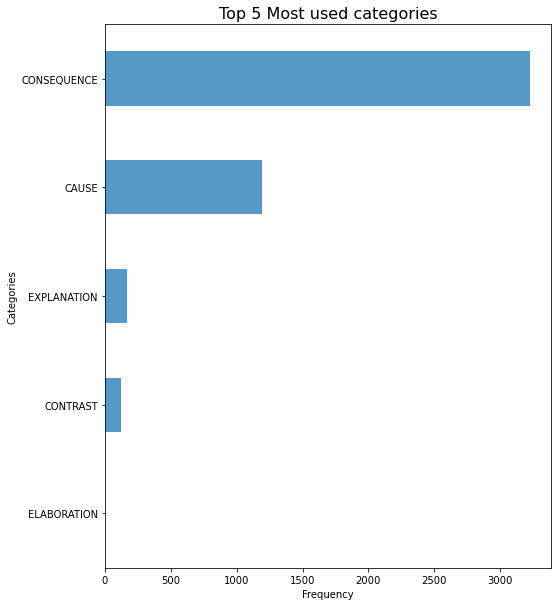

In [13]:
# Plot top N most used categories
x_var = 'categories'
y_var = 'frequency'
title = 'Top %s Most used categories' % min(n_top, len(df))
figsize = (8, 10)
plot_bar_chart(df.sort_values(by=['frequency']), x_var, y_var, title, figsize)

### 2. Most common sub-categories

In [14]:
# Cooking dataframe
top_sub_categories = sub_categories.most_common(n_top)
df = pd.DataFrame.from_records(top_sub_categories, columns = ['subcategories', 'frequency'])
df["% share"] = round(100.0 * df["frequency"] / sum(sub_categories.values()), 2)
df.head(10)

,subcategories,frequency,% share
0,GOAL,3158,67.16
1,CONDITION,662,14.08
2,REASON,527,11.21
3,EXEMPLIFICATION,137,2.91
4,ALTERNATIVE,119,2.53
5,RESULT,68,1.45
6,RESTATEMENT,29,0.62
7,SUMMARY,1,0.02
8,ADDITION,1,0.02


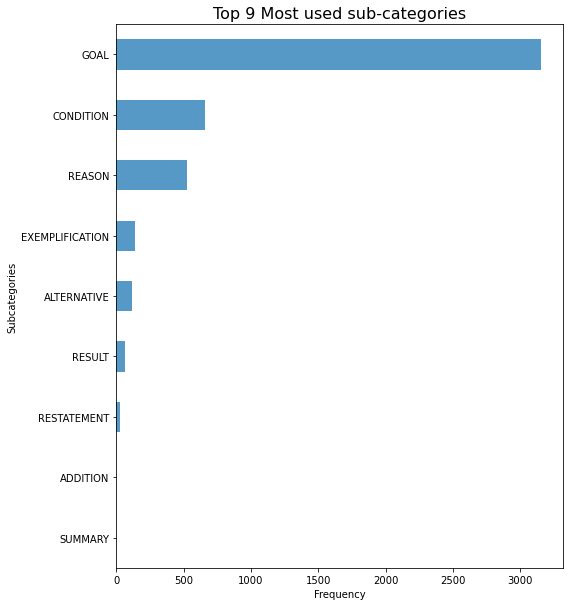

In [15]:
# Plot top N most used sub-categories
x_var = 'subcategories'
y_var = 'frequency'
title = 'Top %s Most used sub-categories' % min(n_top, len(df))
figsize = (8, 10)
plot_bar_chart(df.sort_values(by=['frequency']), x_var, y_var, title, figsize)

### 3. Most used linkers

In [16]:
# Cooking dataframe
top_linkers = linkers.most_common(n_top)
df = pd.DataFrame.from_records(top_linkers, columns = ['linkers', 'frequency'])
df["% share"] = round(100.0 * df["frequency"] / sum(linkers.values()), 2)
df.head(10)

,linkers,frequency,% share
0,para,3115,66.25
1,si,445,9.46
2,ya que,228,4.85
3,porque,160,3.40
4,por ejemplo,90,1.91
5,ante,67,1.42
6,pues,49,1.04
7,ni,42,0.89
8,debido a,40,0.85
9,o,37,0.79


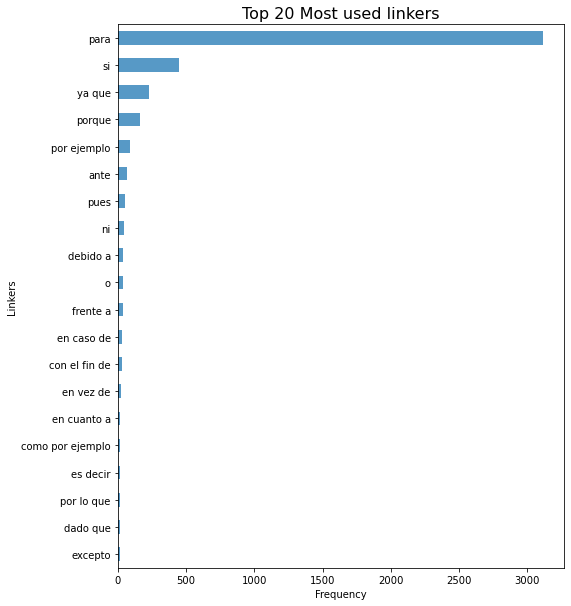

In [17]:
# Plot top N most used linkers
x_var = 'linkers'
y_var = 'frequency'
title = 'Top %s Most used linkers' % min(n_top, len(df))
figsize = (8, 10)
plot_bar_chart(df.sort_values(by=['frequency']), x_var, y_var, title, figsize)

### 4. Most common entities

In [18]:
# Cooking dataframe
top_entities = entities.most_common(n_top)
df = pd.DataFrame.from_records(top_entities, columns = ['entities', 'frequency'])
df["% share"] = round(100.0 * df["frequency"] / sum(entities.values()), 2)
df.head(10)

,entities,frequency,% share
0,Ayuntamiento,102,2.56
1,EMT,55,1.38
2,Vallecas,42,1.06
3,Rio,36,0.90
4,AyuntamientodeMadrid,32,0.80
5,Valdebebas,30,0.75
6,Moratalaz,30,0.75
7,M-30,28,0.70
8,Sanchinarro,28,0.70
9,de,27,0.68


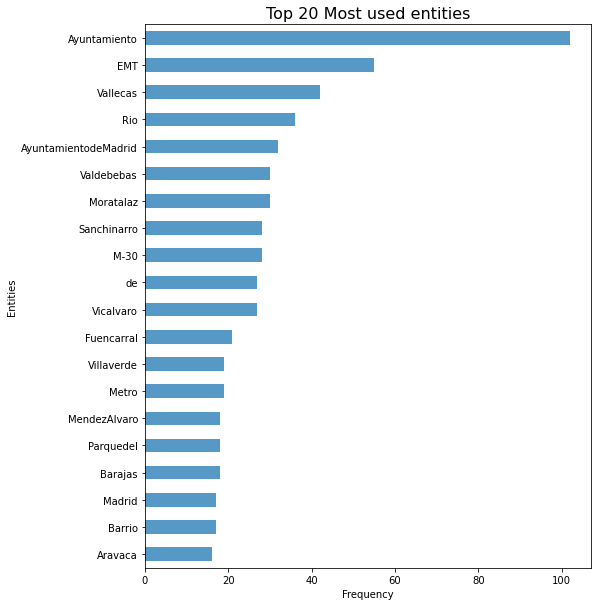

In [19]:
# Plot top N most used entities
x_var = 'entities'
y_var = 'frequency'
title = 'Top %s Most used entities' % min(n_top, len(df))
figsize = (8, 10)
plot_bar_chart(df.sort_values(by=['frequency']), x_var, y_var, title, figsize)

### 5. Most common nouns

In [20]:
# Cooking dataframe
top_nouns = nouns.most_common(n_top)
df = pd.DataFrame.from_records(top_nouns, columns = ['nouns', 'frequency'])
df["% share"] = round(100.0 * df["frequency"] / sum(nouns.values()), 2)
df.head(10)

,nouns,frequency,% share
0,calle,367,1.35
1,zona,336,1.24
2,calles,259,0.95
3,barrio,258,0.95
4,personas,216,0.79
5,parque,212,0.78
6,ciudad,210,0.77
7,uso,189,0.70
8,transporte,189,0.70
9,zonas,186,0.68


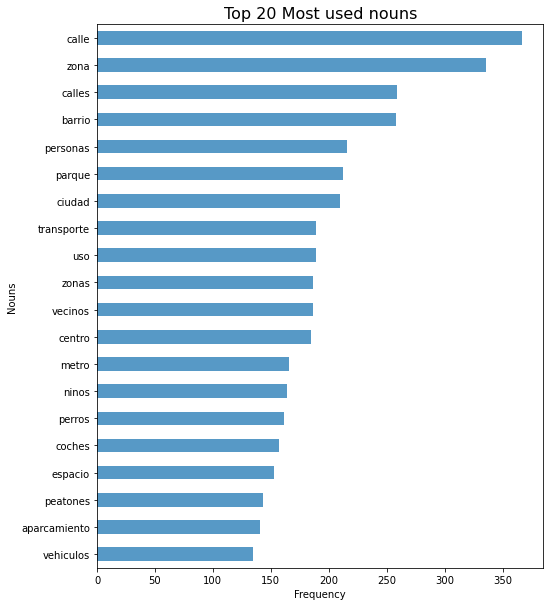

In [21]:
# Plot top N most used nouns
x_var = 'nouns'
y_var = 'frequency'
title = 'Top %s Most used nouns' % min(n_top, len(df))
figsize = (8, 10)
plot_bar_chart(df.sort_values(by=['frequency']), x_var, y_var, title, figsize)

### 6. Most common main verbs

In [22]:
# Cooking dataframe
top_main_verbs = main_verbs.most_common(n_top)
df = pd.DataFrame.from_records(top_main_verbs, columns = ['main verbs', 'frequency'])
df["% share"] = round(100.0 * df["frequency"] / sum(main_verbs.values()), 2)
df.head(10)

,main verbs,frequency,% share
0,propongo,184,4.23
1,crear,171,3.94
2,poner,82,1.89
3,hacer,66,1.52
4,ampliar,62,1.43
5,creo,54,1.24
6,tiene,52,1.20
7,gustaria,48,1.10
8,habilitar,47,1.08
9,tienen,46,1.06


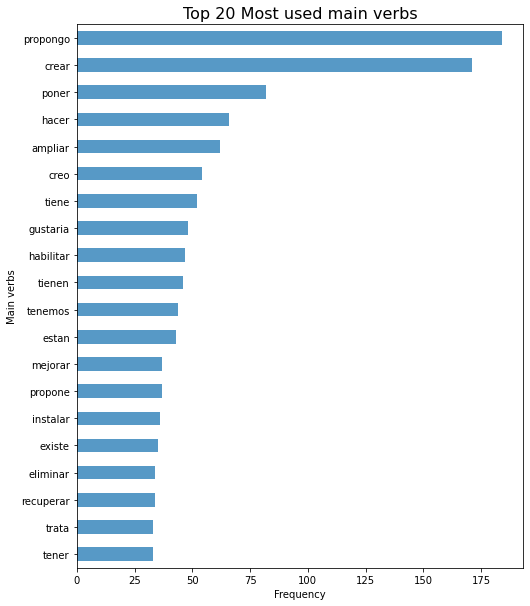

In [23]:
# Plot top N most used main verbs
x_var = 'main verbs'
y_var = 'frequency'
title = 'Top %s Most used main verbs' % min(n_top, len(df))
figsize = (8, 10)
plot_bar_chart(df.sort_values(by=['frequency']), x_var, y_var, title, figsize)

<hr>
<a href="https://github.com/argrecsys/arg-miner">« Back to the repository.</a>